# Module Dependency

In [1]:
%matplotlib inline

import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from skimage.restoration import wiener
from skimage.util import pad
from skimage.filters import laplace, sobel

plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Read input and input_ori

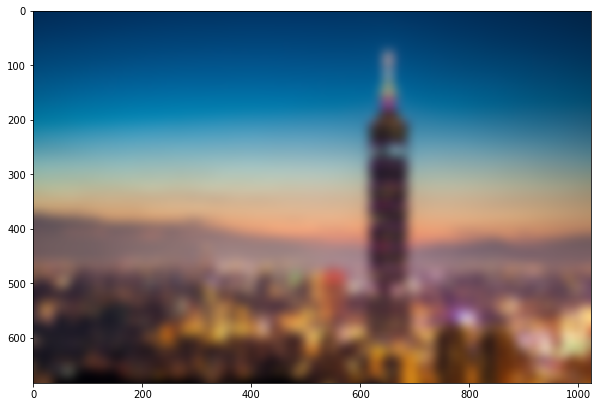

In [2]:
image = io.imread('./data/input1.bmp')
plt.imshow(image)

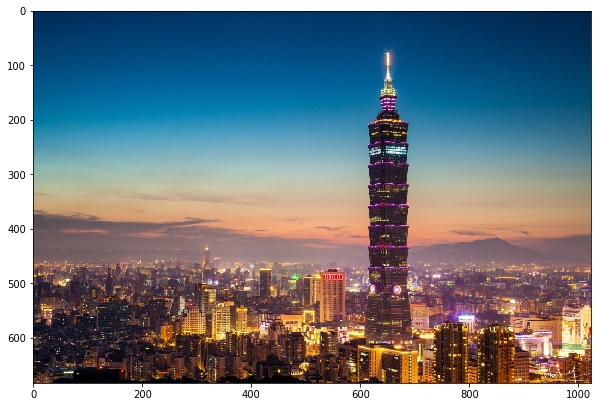

In [3]:
label = io.imread('./data/input1_ori.bmp')
plt.imshow(label)

# Change data type and show shape

In [4]:
image = image.astype('float32')
label = label.astype('float32')

In [5]:
image.shape

(683, 1024, 3)

# Algorithm for finding sigma

In [6]:
def sigma_gen(division, num):
    scale_factor = 2.0 ** (1.0/division)
    level_num = division * num + 1
    sigma = [1]
    for i in range(1, level_num):
        sigma.append(sigma[i-1] * scale_factor)
    return sigma
sigma_list = sigma_gen(10, 5)
len(sigma_list)

51

In [7]:
error_plane = []
filtered = image.copy()
for sigma in sigma_list:
    for i in range(3):
        filtered[:, :, i] = gaussian_filter(image[:, :, i], sigma)
    error_plane.append((sigma, np.linalg.norm(image-filtered)))
len(error_plane)

51

In [8]:
error_plane

[(1, 352.17606),
 (1.0717734625362931, 363.85226),
 (1.1486983549970349, 375.3645),
 (1.231144413344916, 387.08789),
 (1.319507910772894, 399.46487),
 (1.4142135623730947, 413.04282),
 (1.5157165665103978, 428.3139),
 (1.6245047927124707, 445.89948),
 (1.7411011265922478, 466.69815),
 (1.8660659830736144, 491.22586),
 (1.9999999999999996, 520.70929),
 (2.143546925072586, 555.91278),
 (2.2973967099940693, 597.78528),
 (2.4622888266898317, 647.78009),
 (2.6390158215457875, 706.91156),
 (2.828427124746189, 776.19812),
 (3.0314331330207946, 857.5683),
 (3.2490095854249406, 952.14001),
 (3.4822022531844947, 1061.4454),
 (3.7321319661472274, 1187.1077),
 (3.9999999999999973, 1330.8468),
 (4.28709385014517, 1494.475),
 (4.594793419988137, 1679.8857),
 (4.924577653379662, 1889.7826),
 (5.278031643091573, 2124.9087),
 (5.656854249492376, 2388.5474),
 (6.0628662660415875, 2681.4827),
 (6.4980191708498785, 3006.9316),
 (6.964404506368987, 3365.9783),
 (7.464263932294452, 3760.2012),
 (7.999999999

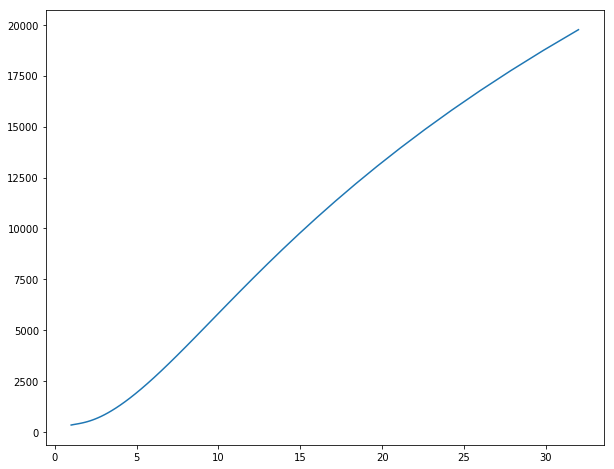

In [9]:
plt.plot(*zip(*error_plane))

In [10]:
max_diff = 0
max_sigma = 0
for i, error_pair in enumerate(error_plane[:-1]):
    sigma_1 = error_pair[0]
    sigma_2 = error_plane[i+1][0]
    error_1 = error_pair[1]
    error_2 = error_plane[i+1][1]
    diff = (error_2 - error_1)/(sigma_2 - sigma_1)
    if diff > max_diff:
        max_diff = diff
        max_sigma = sigma_1
print(max_sigma, max_diff)    

9.18958683997627 824.997866831


# Create kernel based on predicted sigma

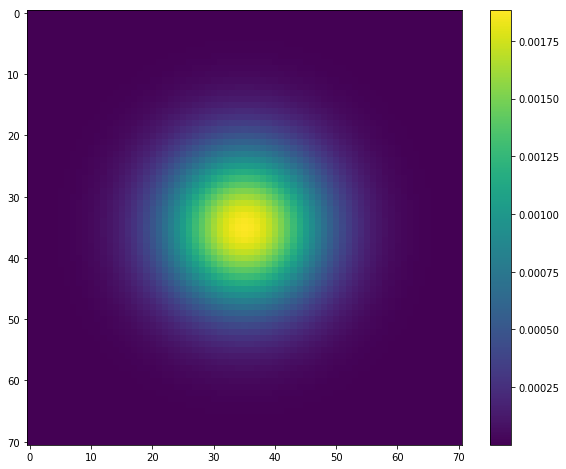

In [11]:
kernel = np.zeros((71, 71), dtype='float32')
kernel[35][35] = 1.
kernel = gaussian_filter(kernel, max_sigma)

plt.imshow(kernel)
plt.colorbar()
plt.show()
# print(kernel.shape)

# Pad the image

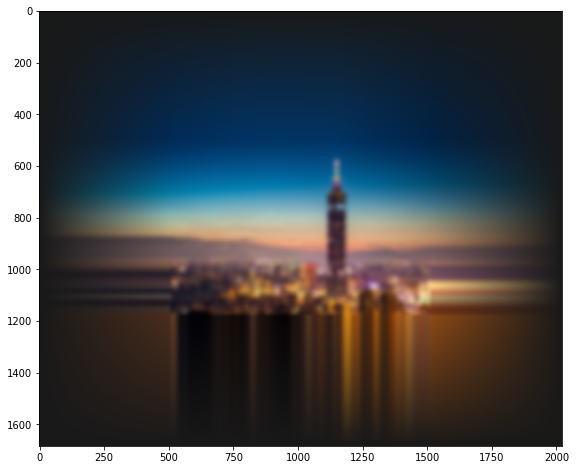

In [12]:
image_pad = np.zeros((image.shape[0]+1000, image.shape[1]+1000, 3))
for i in range(3):
    image_pad[:, :, i] = pad(image[:, :, i], 500, mode='linear_ramp', end_values=25)
plt.imshow(image_pad.astype('uint8'))

# Wiener filter implementation

In [13]:
def uirfftn(inarray, dim=2, shape=None):
    outarray = np.fft.irfftn(inarray, shape, axes=range(-dim, 0))
    return outarray

In [14]:
def urfftn(inarray, dim=2):
    outarray = np.fft.rfftn(inarray, axes=range(-dim, 0))
    return outarray

In [15]:
def ir2tf(imp_resp, shape, dim=None):
    """
    Impluse Response to transfer function
    """
    if not dim:
        dim = imp_resp.ndim
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):
        if axis >= imp_resp.ndim - dim:
            irpadded = np.roll(irpadded,
                               shift=-int(np.floor(axis_size / 2)),
                               axis=axis)
    return np.fft.rfftn(irpadded, axes=range(-dim, 0))

In [16]:
def laplacian(ndim, shape):
    impr = np.zeros([3] * ndim)
    for dim in range(ndim):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (ndim - dim - 1))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(ndim)])
    impr[([slice(1, 2)] * ndim)] = 2.0 * ndim
    return ir2tf(impr, shape), impr

In [17]:
def wiener(image, psf, balance, reg=None):
    reg, _ = laplacian(image.ndim, image.shape)
    trans_func = ir2tf(psf, image.shape)
    wiener_filter = np.conj(trans_func) / (np.abs(trans_func) ** 2 + balance * np.abs(reg) ** 2)
    deconv = uirfftn(wiener_filter * urfftn(image), shape=image.shape)
    return deconv

# Restoration and clip illegal data

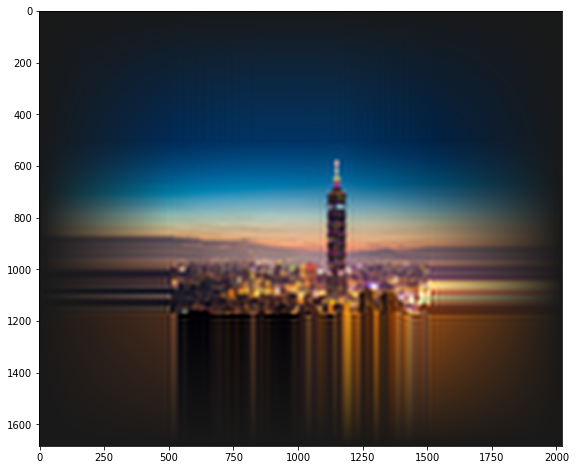

In [18]:
# image_new = image.copy()
# for i in range(3):
#     image_new[:, :, i] = gaussian_filter(image_new[:, :, i], 3)
for i in range(3):
    image_pad[:, :, i] = wiener(image_pad[:, :, i], kernel, 1)
image_pad[image_pad > 255] = 255
image_pad[image_pad < 0] = 0
plt.imshow(image_pad.astype('uint8'))

# Get original image size

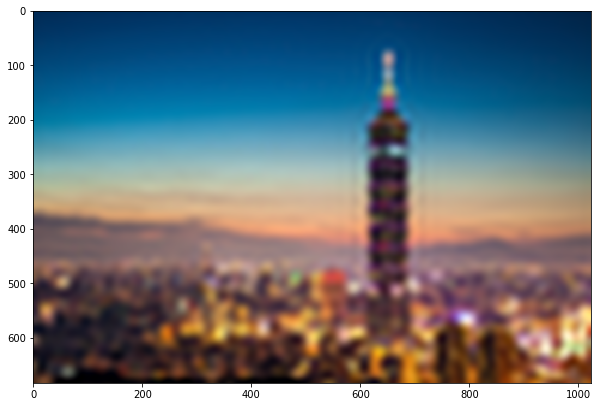

In [19]:
image_new = image.copy()
image_new = image_pad[500:-500, 500:-500, :]
plt.imshow(image_new.astype('uint8'))

# PSNR function and calculate PSNR

In [20]:
def psnr(im1,im2):
    psnr = 0
    for i in range(im1.shape[2]):
        diff = np.abs(im1[:, :, i].astype('float64') - im2[:, :, i].astype('float64'))
        rmse = (np.square(diff).sum())/(im1.shape[0] * im1.shape[1])
        psnr += 10*np.log10((255**2)/rmse)
    return psnr

In [21]:
print('Initail PSNR: {}'.format(psnr(label, image)))
print('After restoration: {}'.format(psnr(label, image_new)))

Initail PSNR: 65.29286159552628
After restoration: 67.77563641690412


# Save output image

In [22]:
io.imsave('./data/output1.bmp' ,image_new.astype('uint8'))

# The codes below are used for report

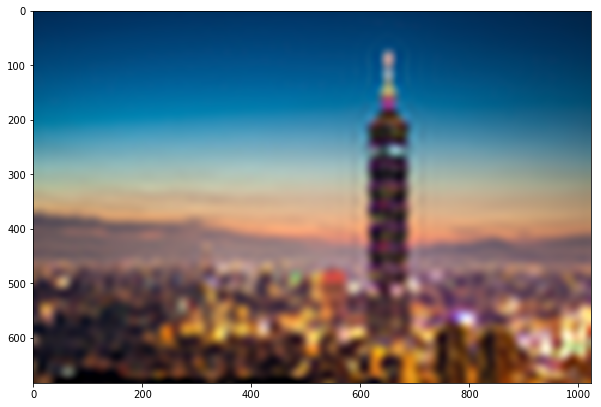

In [22]:
image_sharp = image_new.copy()
for i in range(3):
    image_sharp[:, :, i] += sobel(image_new[:, :, i].astype('uint8'))
plt.imshow(image_sharp.astype('uint8'))

In [23]:
print('Initail PSNR: {}'.format(psnr(label, image)))
print('After restoration: {}'.format(psnr(label, image_sharp)))

Initail PSNR: 96.37146909638308
After restoration: 97.68804183660018


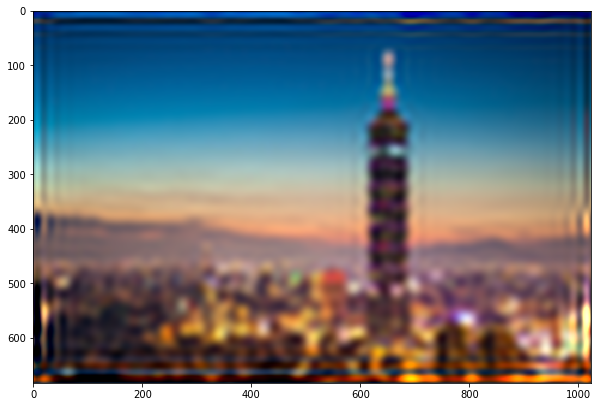

In [24]:
image_no_pad = image.copy()
for i in range(3):
    image_no_pad[:, :, i] = wiener(image_no_pad[:, :, i], kernel, 1)
image_no_pad[image_no_pad > 255] = 255
image_no_pad[image_no_pad < 0] = 0
plt.imshow(image_no_pad.astype('uint8'))

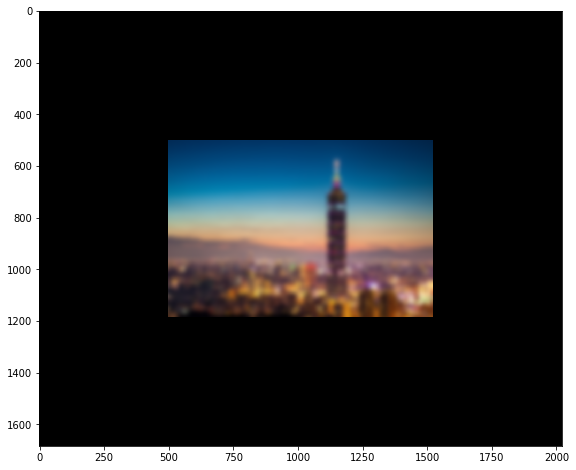

In [25]:
image_zero_pad = np.zeros((image.shape[0]+1000, image.shape[1]+1000, 3))
for i in range(3):
    image_zero_pad[:, :, i] = pad(image[:, :, i], 500, mode='constant', constant_values=0)
plt.imshow(image_zero_pad.astype('uint8'))

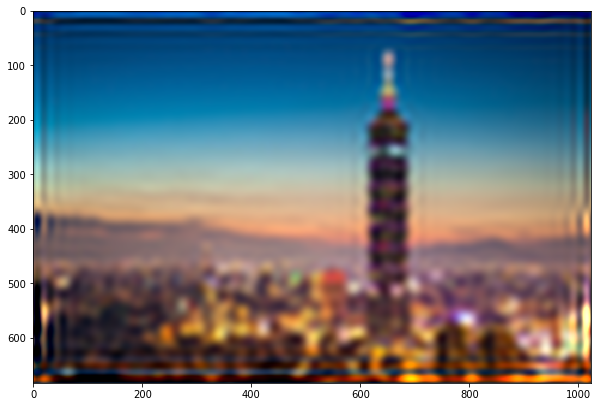

In [26]:
for i in range(3):
    image_zero_pad[:, :, i] = wiener(image_zero_pad[:, :, i], kernel, 1)
image_no_pad[image_no_pad > 255] = 255
image_no_pad[image_no_pad < 0] = 0
plt.imshow(image_no_pad.astype('uint8'))